# 🦷 Entrenamiento con Radiografías Dentales - Dataset Flexible

Este notebook permite entrenar un modelo YOLOv8/v10 usando:
- **Dataset local**: carpeta `images/datos_radiografias` 
- **Dataset de Kaggle**: descarga automática desde [Radiografías Panorámicas Dentales](https://www.kaggle.com/datasets/nataliamorenomontoya/radiografas-panormicas-dentales)

## Flujo del notebook:
1. Configurar origen del dataset (local o Kaggle)
2. Explorar estructura del dataset
3. Preparar datos para YOLO automáticamente
4. Entrenar modelo
5. Evaluar resultados

**Configuración**: Cambia `USE_LOCAL_DATASET = True/False` en la celda 2 para seleccionar el origen.

## 1. Instalación de Dependencias

In [ ]:
# Instalar paquetes necesarios
!pip install kagglehub ultralytics --quiet

print("✅ Paquetes instalados")

## 2. Configurar Ruta del Dataset

Puedes usar dataset de Kaggle (descarga automática) o dataset local en `images/datos_radiografias`

In [1]:
# Opción 1: Usar dataset local
USE_LOCAL_DATASET = True  # Cambiar a False para descargar desde Kaggle

if USE_LOCAL_DATASET:
    # Usar dataset local
    import os
    from pathlib import Path
    BASE_DIR = Path(r"C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA")
    path = str(BASE_DIR / "images" / "datos_radiografias")
    print(f"Usando dataset local: {path}")

    if not os.path.exists(path):
        print(f"⚠️ ADVERTENCIA: No se encontró la carpeta {path}")
        print("   Creando carpeta...")
        os.makedirs(path, exist_ok=True)
else:
    # Opción 2: Descargar desde Kaggle
    import kagglehub
    path = kagglehub.dataset_download("nataliamorenomontoya/radiografas-panormicas-dentales")
    print(f"Dataset descargado de Kaggle: {path}")

Usando dataset local: C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\images\datos_radiografias


## 3. Importar Librerías

In [2]:
import os
import shutil
import random
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json
from collections import Counter

# Configurar semilla para reproducibilidad
random.seed(42)
np.random.seed(42)

print("✅ Librerías importadas correctamente!")

✅ Librerías importadas correctamente!


## 4. Explorar Estructura del Dataset

In [3]:
# Configurar rutas
KAGGLE_DATA_PATH = Path(path)
BASE_DIR = Path(r"C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA")
DATASET_DIR = BASE_DIR / "dataset_dental_kaggle"

print(f"Dataset Kaggle ubicado en: {KAGGLE_DATA_PATH}")
print(f"\nContenido del directorio:")

# Explorar estructura
for item in KAGGLE_DATA_PATH.rglob("*"):
    if item.is_file():
        rel_path = item.relative_to(KAGGLE_DATA_PATH)
        print(f"  {rel_path}")
        if len(list(KAGGLE_DATA_PATH.rglob("*"))) > 50:
            print("  ... (más archivos)")
            break

Dataset Kaggle ubicado en: C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\images\datos_radiografias

Contenido del directorio:
  test\images\img (1095).png
  ... (más archivos)


In [4]:
# Detectar formato del dataset
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
annotation_files = list(KAGGLE_DATA_PATH.rglob("*.txt")) + list(KAGGLE_DATA_PATH.rglob("*.json")) + list(KAGGLE_DATA_PATH.rglob("*.xml"))
image_files = [f for f in KAGGLE_DATA_PATH.rglob("*") if f.suffix.lower() in image_extensions]

print(f"\nEstadísticas:")
print(f"  Total de imágenes encontradas: {len(image_files)}")
print(f"  Total de archivos de anotaciones: {len(annotation_files)}")

if annotation_files:
    print(f"\nFormatos de anotación detectados:")
    for ext in set(f.suffix for f in annotation_files):
        count = len([f for f in annotation_files if f.suffix == ext])
        print(f"  {ext}: {count} archivos")


Estadísticas:
  Total de imágenes encontradas: 937
  Total de archivos de anotaciones: 937

Formatos de anotación detectados:
  .txt: 937 archivos


In [5]:
# Verificar si ya está en formato YOLO
def check_yolo_format(data_path):
    """
    Verifica si el dataset ya está en formato YOLO
    (estructura: train/images, train/labels, val/images, val/labels)
    """
    train_images = data_path / "train" / "images"
    train_labels = data_path / "train" / "labels"
    val_images = data_path / "val" / "images"
    val_labels = data_path / "val" / "labels"
    
    # Buscar también variaciones comunes
    alt_patterns = [
        (data_path / "images" / "train", data_path / "labels" / "train"),
        (data_path / "images", data_path / "labels"),
    ]
    
    if train_images.exists() and train_labels.exists():
        return "yolo_standard", (train_images, train_labels, val_images, val_labels)
    
    for img_path, lbl_path in alt_patterns:
        if img_path.exists() and lbl_path.exists():
            return "yolo_alt", (img_path, lbl_path, None, None)
    
    return None, None

format_type, paths = check_yolo_format(KAGGLE_DATA_PATH)

if format_type:
    print(f"✅ Dataset ya está en formato YOLO ({format_type})")
    print(f"  Rutas detectadas:")
    print(f"    Train images: {paths[0]}")
    print(f"    Train labels: {paths[1]}")
    if paths[2]:
        print(f"    Val images: {paths[2]}")
        print(f"    Val labels: {paths[3]}")
else:
    print("⚠️ Dataset no está en formato YOLO estándar")
    print("   Se requerirá conversión manual")

✅ Dataset ya está en formato YOLO (yolo_standard)
  Rutas detectadas:
    Train images: C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\images\datos_radiografias\train\images
    Train labels: C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\images\datos_radiografias\train\labels
    Val images: C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\images\datos_radiografias\val\images
    Val labels: C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\images\datos_radiografias\val\labels


## 5. Detectar Clases del Dataset

In [7]:
# Buscar archivo de clases
classes_files = list(KAGGLE_DATA_PATH.rglob("classes.txt")) + \
                list(KAGGLE_DATA_PATH.rglob("class*.txt")) + \
                list(KAGGLE_DATA_PATH.rglob("data.yaml")) + \
                list(KAGGLE_DATA_PATH.rglob("dataset.yaml"))

CLASSES = []

if classes_files:
    print("Archivos de configuración encontrados:")
    for cf in classes_files:
        print(f"  - {cf.name}")
    
    # Intentar leer clases
    classes_file = classes_files[0]
    print(f"\nLeyendo clases desde: {classes_file.name}")
    
    with open(classes_file, 'r', encoding='utf-8') as f:
        content = f.read()
        print("\nContenido:")
        print(content[:500])  # Primeros 500 caracteres
        
        # Intentar parsear como lista simple
        CLASSES = [line.strip() for line in content.split('\n') if line.strip() and not line.startswith('#')]
else:
    print("⚠️ No se encontró archivo de clases")
    print("   Intentando detectar clases desde anotaciones...")
    
    # Intentar detectar desde archivos .txt YOLO
    txt_files = list(KAGGLE_DATA_PATH.rglob("*.txt"))
    class_ids = set()
    
    for txt_file in txt_files[:100]:  # Revisar primeros 100 archivos
        try:
            with open(txt_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:  # Formato YOLO: class x y w h
                        class_ids.add(int(parts[0]))
        except:
            pass
    
    if class_ids:
        max_class = max(class_ids)
        CLASSES = [f"class_{i}" for i in range(max_class + 1)]
        print(f"✅ Detectadas {len(CLASSES)} clases (class_0 a class_{max_class})")

print(f"\nTotal de clases: {len(CLASSES)}")
if CLASSES:
    print("\nClases encontradas:")
    for i, cls in enumerate(CLASSES):
        print(f"  {i}. {cls}")

Archivos de configuración encontrados:
  - classes.txt
  - classes.txt

Leyendo clases desde: classes.txt

Contenido:
tratamiento_conducto
fractura
diastema
cordales
quiste_periapical
diente_retenido
caries
zona_dentula
dientes_sanos
apinamiento
diente_rotado
supernumerario
enanismo_radicular
residuo_radicular


Total de clases: 14

Clases encontradas:
  0. tratamiento_conducto
  1. fractura
  2. diastema
  3. cordales
  4. quiste_periapical
  5. diente_retenido
  6. caries
  7. zona_dentula
  8. dientes_sanos
  9. apinamiento
  10. diente_rotado
  11. supernumerario
  12. enanismo_radicular
  13. residuo_radicular


## 6. Visualizar Muestras del Dataset

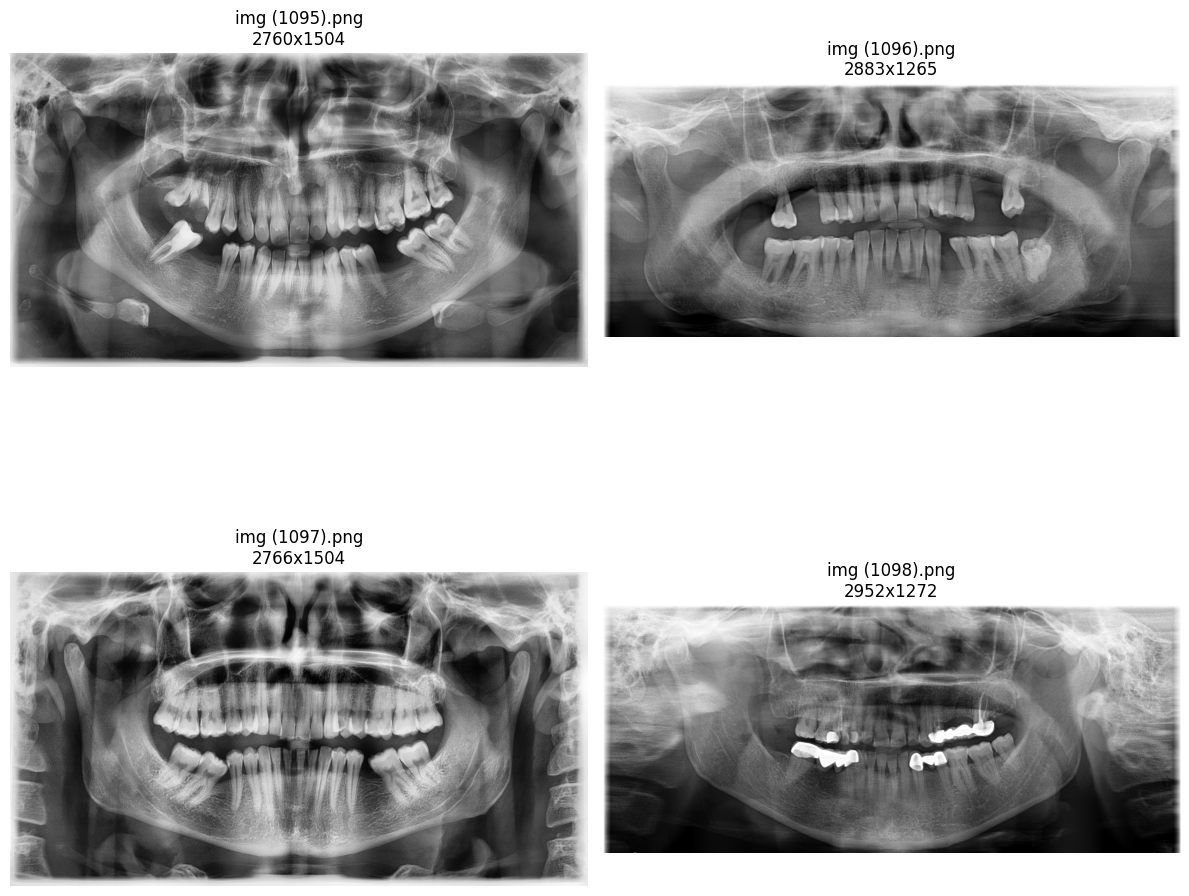

In [8]:
# Mostrar algunas imágenes de ejemplo
sample_images = image_files[:4] if len(image_files) >= 4 else image_files

if sample_images:
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray' if img.mode == 'L' else None)
        axes[i].set_title(f"{img_path.name}\n{img.size[0]}x{img.size[1]}")
        axes[i].axis('off')
    
    # Ocultar ejes vacíos
    for i in range(len(sample_images), 4):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron imágenes para visualizar")

## 7. Preparar Dataset para YOLO

In [9]:
# Si ya está en formato YOLO, copiar/enlazar los directorios
if format_type == "yolo_standard":
    print("Dataset ya está en formato YOLO estándar")
    print("Usando rutas directas del dataset...")
    
    # Usar las rutas directamente
    train_images_dir = paths[0]
    train_labels_dir = paths[1]
    val_images_dir = paths[2] if paths[2] and paths[2].exists() else None
    val_labels_dir = paths[3] if paths[3] and paths[3].exists() else None
    
    DATASET_DIR = KAGGLE_DATA_PATH
    
elif format_type == "yolo_alt":
    print("Dataset en formato YOLO alternativo")
    print("Creando estructura estándar...")
    
    # Crear directorios
    train_images_dir = DATASET_DIR / "train" / "images"
    train_labels_dir = DATASET_DIR / "train" / "labels"
    val_images_dir = DATASET_DIR / "val" / "images"
    val_labels_dir = DATASET_DIR / "val" / "labels"
    
    for d in [train_images_dir, train_labels_dir, val_images_dir, val_labels_dir]:
        d.mkdir(parents=True, exist_ok=True)
    
    # Obtener todas las imágenes y sus labels
    src_images_dir = paths[0]
    src_labels_dir = paths[1]
    
    all_images = list(src_images_dir.glob("*.*"))
    all_images = [img for img in all_images if img.suffix.lower() in image_extensions]
    
    # Filtrar solo imágenes con labels
    images_with_labels = []
    for img in all_images:
        label_file = src_labels_dir / f"{img.stem}.txt"
        if label_file.exists():
            images_with_labels.append(img)
    
    print(f"Imágenes con anotaciones: {len(images_with_labels)}")
    
    # Dividir en train/val
    random.shuffle(images_with_labels)
    split_idx = int(len(images_with_labels) * 0.8)
    train_imgs = images_with_labels[:split_idx]
    val_imgs = images_with_labels[split_idx:]
    
    print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}")
    
    # Copiar archivos
    print("Copiando archivos de entrenamiento...")
    for img in train_imgs:
        shutil.copy(img, train_images_dir / img.name)
        label = src_labels_dir / f"{img.stem}.txt"
        if label.exists():
            shutil.copy(label, train_labels_dir / label.name)
    
    print("Copiando archivos de validación...")
    for img in val_imgs:
        shutil.copy(img, val_images_dir / img.name)
        label = src_labels_dir / f"{img.stem}.txt"
        if label.exists():
            shutil.copy(label, val_labels_dir / label.name)
    
    print("✅ Dataset preparado")

else:
    print("⚠️ Preparando dataset desde carpeta local images/datos_radiografias...")
    
    # Crear directorios
    train_images_dir = DATASET_DIR / "train" / "images"
    train_labels_dir = DATASET_DIR / "train" / "labels"
    val_images_dir = DATASET_DIR / "val" / "images"
    val_labels_dir = DATASET_DIR / "val" / "labels"
    
    for d in [train_images_dir, train_labels_dir, val_images_dir, val_labels_dir]:
        d.mkdir(parents=True, exist_ok=True)
    
    # Buscar imágenes y labels en la carpeta
    print(f"Buscando archivos en: {KAGGLE_DATA_PATH}")
    
    # Buscar imágenes
    all_images = []
    for ext in image_extensions:
        all_images.extend(list(KAGGLE_DATA_PATH.rglob(f"*{ext}")))
    
    print(f"Total de imágenes encontradas: {len(all_images)}")
    
    # Filtrar imágenes con labels
    images_with_labels = []
    for img in all_images:
        # Buscar archivo de label correspondiente
        label_file = img.with_suffix(".txt")
        if label_file.exists() and label_file.name != "classes.txt":
            images_with_labels.append(img)
    
    print(f"Imágenes con anotaciones: {len(images_with_labels)}")
    
    if len(images_with_labels) == 0:
        print("❌ ERROR: No se encontraron imágenes con anotaciones")
        print(f"   Verifica que la carpeta {KAGGLE_DATA_PATH} contenga:")
        print("   - Imágenes (.jpg, .jpeg, .png, .bmp)")
        print("   - Archivos de anotación (.txt) con el mismo nombre que las imágenes")
    else:
        # Dividir en train/val
        random.shuffle(images_with_labels)
        split_idx = int(len(images_with_labels) * 0.8)
        train_imgs = images_with_labels[:split_idx]
        val_imgs = images_with_labels[split_idx:]
        
        print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}")
        
        # Copiar archivos de entrenamiento
        print("Copiando archivos de entrenamiento...")
        for i, img in enumerate(train_imgs):
            # Normalizar nombre
            new_name = img.stem.replace(" ", "_").replace("(", "").replace(")", "")
            
            shutil.copy(img, train_images_dir / f"{new_name}{img.suffix}")
            label = img.with_suffix(".txt")
            if label.exists():
                shutil.copy(label, train_labels_dir / f"{new_name}.txt")
            
            if (i + 1) % 50 == 0:
                print(f"  Procesadas {i + 1}/{len(train_imgs)}")
        
        # Copiar archivos de validación
        print("Copiando archivos de validación...")
        for i, img in enumerate(val_imgs):
            new_name = img.stem.replace(" ", "_").replace("(", "").replace(")", "")
            
            shutil.copy(img, val_images_dir / f"{new_name}{img.suffix}")
            label = img.with_suffix(".txt")
            if label.exists():
                shutil.copy(label, val_labels_dir / f"{new_name}.txt")
        
        print("✅ Dataset preparado desde carpeta local")

Dataset ya está en formato YOLO estándar
Usando rutas directas del dataset...


## 8. Análisis de Distribución de Clases

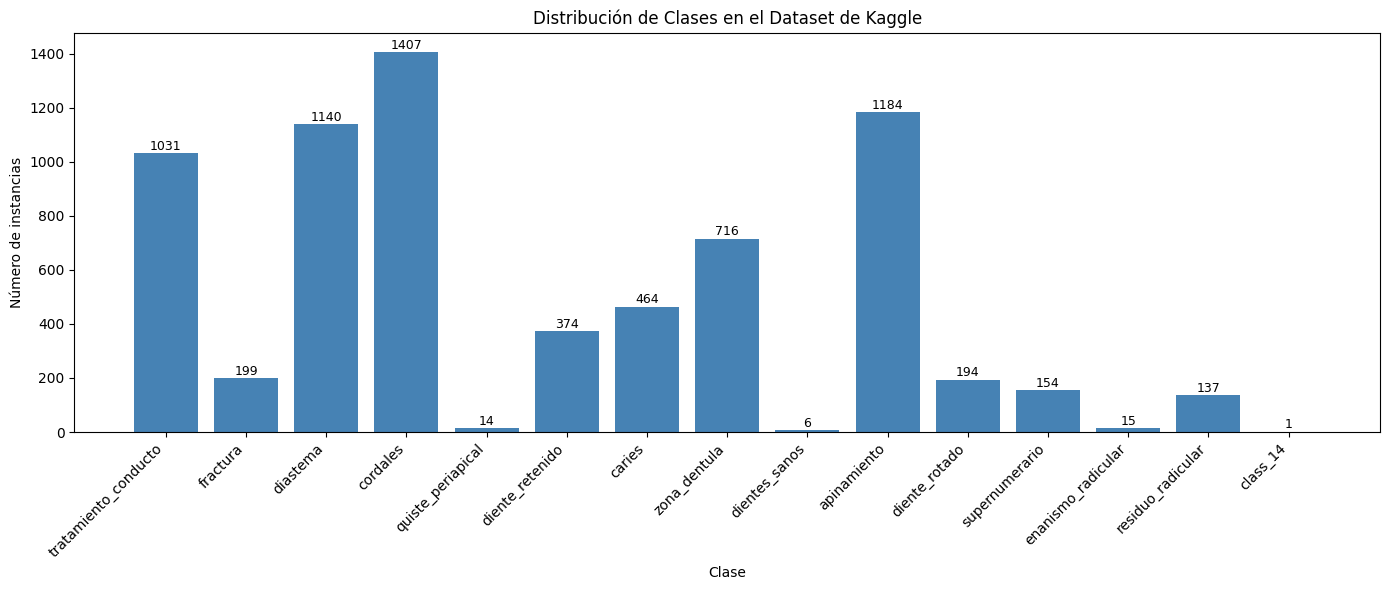


Resumen de distribución:
 0. tratamiento_conducto          : 1031 ( 14.7%)
 1. fractura                      :  199 (  2.8%)
 2. diastema                      : 1140 ( 16.2%)
 3. cordales                      : 1407 ( 20.0%)
 4. quiste_periapical             :   14 (  0.2%)
 5. diente_retenido               :  374 (  5.3%)
 6. caries                        :  464 (  6.6%)
 7. zona_dentula                  :  716 ( 10.2%)
 8. dientes_sanos                 :    6 (  0.1%)
 9. apinamiento                   : 1184 ( 16.8%)
10. diente_rotado                 :  194 (  2.8%)
11. supernumerario                :  154 (  2.2%)
12. enanismo_radicular            :   15 (  0.2%)
13. residuo_radicular             :  137 (  1.9%)
14. class_14                      :    1 (  0.0%)

Total de anotaciones: 7036


In [10]:
# Contar instancias por clase
if 'train_labels_dir' in locals() and train_labels_dir:
    class_counts = Counter()
    
    for label_file in train_labels_dir.glob("*.txt"):
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    class_counts[class_id] += 1
    
    # Visualizar distribución
    if class_counts:
        plt.figure(figsize=(14, 6))
        classes_present = sorted(class_counts.keys())
        counts = [class_counts[i] for i in classes_present]
        
        bars = plt.bar(classes_present, counts, color='steelblue')
        
        if CLASSES:
            labels = [CLASSES[i] if i < len(CLASSES) else f"class_{i}" for i in classes_present]
            plt.xticks(classes_present, labels, rotation=45, ha='right')
        
        plt.xlabel('Clase')
        plt.ylabel('Número de instancias')
        plt.title('Distribución de Clases en el Dataset de Kaggle')
        
        # Añadir valores
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                     str(count), ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Resumen
        print("\nResumen de distribución:")
        total = sum(class_counts.values())
        for class_id in sorted(class_counts.keys()):
            count = class_counts[class_id]
            percentage = (count / total * 100) if total > 0 else 0
            class_name = CLASSES[class_id] if class_id < len(CLASSES) else f"class_{class_id}"
            print(f"{class_id:2d}. {class_name:30s}: {count:4d} ({percentage:5.1f}%)")
        print(f"\nTotal de anotaciones: {total}")
else:
    print("No se pudo analizar la distribución de clases")

## 9. Crear Archivo de Configuración YAML

In [11]:
# Crear archivo data.yaml
if CLASSES:
    yaml_content = f"""# Dataset configuration for Kaggle Dental Panoramic X-rays
path: {DATASET_DIR.as_posix()}
train: train/images
val: val/images

# Classes
names:
"""
    
    for i, class_name in enumerate(CLASSES):
        yaml_content += f"  {i}: {class_name}\n"
    
    yaml_path = DATASET_DIR / "data.yaml"
    with open(yaml_path, "w", encoding="utf-8") as f:
        f.write(yaml_content)
    
    print(f"✅ Archivo de configuración creado: {yaml_path}")
    print("\nContenido:")
    print(yaml_content)
else:
    print("⚠️ No se pudieron detectar las clases. Crea el archivo data.yaml manualmente.")

✅ Archivo de configuración creado: C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\images\datos_radiografias\data.yaml

Contenido:
# Dataset configuration for Kaggle Dental Panoramic X-rays
path: C:/Users/memer/OneDrive/Documentos/pathU/proyecto_ia/proyecto_IA/images/datos_radiografias
train: train/images
val: val/images

# Classes
names:
  0: tratamiento_conducto
  1: fractura
  2: diastema
  3: cordales
  4: quiste_periapical
  5: diente_retenido
  6: caries
  7: zona_dentula
  8: dientes_sanos
  9: apinamiento
  10: diente_rotado
  11: supernumerario
  12: enanismo_radicular
  13: residuo_radicular



## 10. Configurar Hiperparámetros

In [12]:
# Configuración de entrenamiento

# Modelo (opciones: yolov8n, yolov8s, yolov8m, yolov8l, yolov8x)
# O YOLOv10: yolov10n, yolov10s, yolov10m, yolov10b, yolov10l, yolov10x
MODEL_NAME = "yolov8n.pt"  # Cambiar a yolov10n.pt para YOLOv10

EPOCHS = 100
IMG_SIZE = 640
BATCH_SIZE = 16
PATIENCE = 20
PROJECT_NAME = "dental_kaggle"

print("Configuración de entrenamiento:")
print(f"  Modelo: {MODEL_NAME}")
print(f"  Epochs: {EPOCHS}")
print(f"  Image size: {IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Patience: {PATIENCE}")

Configuración de entrenamiento:
  Modelo: yolov8n.pt
  Epochs: 100
  Image size: 640
  Batch size: 16
  Patience: 20


## 11. Entrenar el Modelo

In [13]:
# Cargar modelo
if 'yaml_path' in locals() and yaml_path.exists():
    model = YOLO(MODEL_NAME)
    print(f"✅ Modelo {MODEL_NAME} cargado")
else:
    print("❌ Error: No se encontró el archivo data.yaml")
    print("Por favor, verifica que el dataset se haya preparado correctamente")

✅ Modelo yolov8n.pt cargado


In [14]:
# Entrenar
if 'model' in locals() and 'yaml_path' in locals():
    results = model.train(
        data=str(yaml_path),
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        name=PROJECT_NAME,
        project=str(BASE_DIR / "runs"),
        cache=True,
        patience=PATIENCE,
        save=True,
        plots=True,
        verbose=True
    )
    
    print("\n" + "="*50)
    print("✅ ENTRENAMIENTO COMPLETADO")
    print("="*50)
else:
    print("⚠️ No se puede iniciar el entrenamiento. Verifica la configuración.")

New https://pypi.org/project/ultralytics/8.3.229 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.220  Python-3.12.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\images\datos_radiografias\data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8

## 12. Evaluar el Modelo

In [15]:
# Cargar mejor modelo
best_model_path = BASE_DIR / "runs" / PROJECT_NAME / "weights" / "best.pt"

if best_model_path.exists():
    best_model = YOLO(str(best_model_path))
    print(f"✅ Modelo cargado: {best_model_path}")
else:
    runs_dir = BASE_DIR / "runs"
    project_dirs = [d for d in runs_dir.iterdir() if d.is_dir() and PROJECT_NAME in d.name]
    if project_dirs:
        latest = max(project_dirs, key=lambda x: x.stat().st_mtime)
        best_model_path = latest / "weights" / "best.pt"
        best_model = YOLO(str(best_model_path))
        print(f"✅ Modelo cargado: {best_model_path}")

✅ Modelo cargado: C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\runs\dental_kaggle\weights\best.pt


In [16]:
# Validar modelo
if 'best_model' in locals():
    metrics = best_model.val()
    
    print("\nMétricas de validación:")
    print(f"  mAP50: {metrics.box.map50:.4f}")
    print(f"  mAP50-95: {metrics.box.map:.4f}")
    print(f"  Precision: {metrics.box.mp:.4f}")
    print(f"  Recall: {metrics.box.mr:.4f}")

Ultralytics 8.3.220  Python-3.12.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,378 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.30.1 ms, read: 376.3348.8 MB/s, size: 762.3 KB)
val: Scanning C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\images\datos_radiografias\val\labels.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 0.7it/s 8.7s0.2s
                   all         93        563      0.432      0.272      0.266      0.103
  tratamiento_conducto         37         96      0.715      0.549      0.609      0.176
              fractura          3          3          0          0    0.00735    0.00365
              diastema         23         70      0.274      0.343      0.154     0.0443
              cordales         72        224      0.831 

## 13. Visualizar Resultados

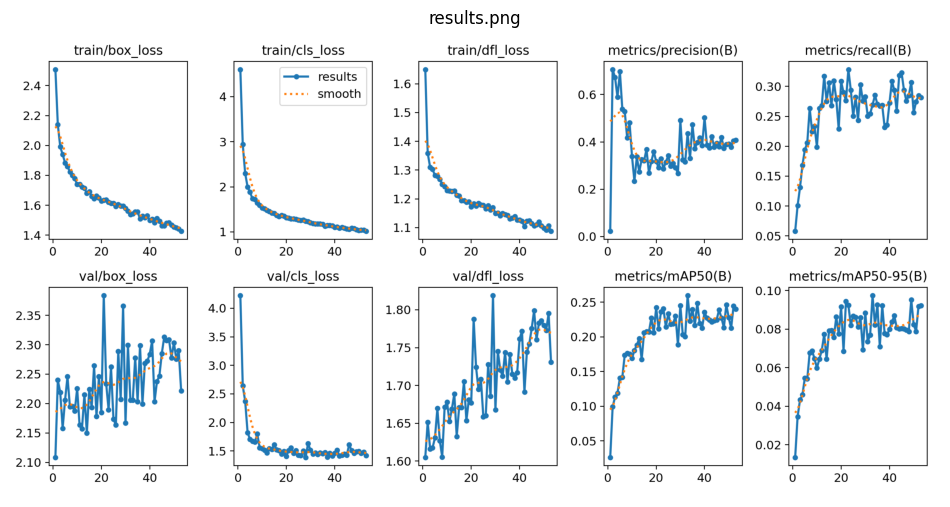

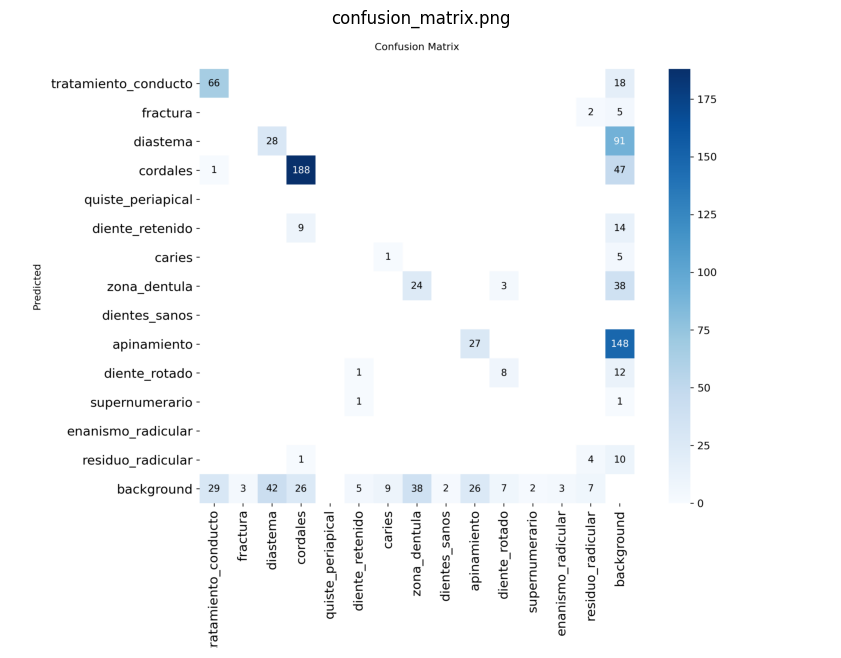

No encontrado: F1_curve.png
No encontrado: PR_curve.png


In [17]:
# Mostrar gráficas de entrenamiento
if 'best_model_path' in locals():
    results_dir = best_model_path.parent.parent
    
    result_images = [
        "results.png",
        "confusion_matrix.png",
        "F1_curve.png",
        "PR_curve.png"
    ]
    
    for img_name in result_images:
        img_path = results_dir / img_name
        if img_path.exists():
            img = Image.open(img_path)
            plt.figure(figsize=(12, 8))
            plt.imshow(img)
            plt.title(img_name)
            plt.axis('off')
            plt.show()
        else:
            print(f"No encontrado: {img_name}")

## 14. Probar con Imágenes de Validación

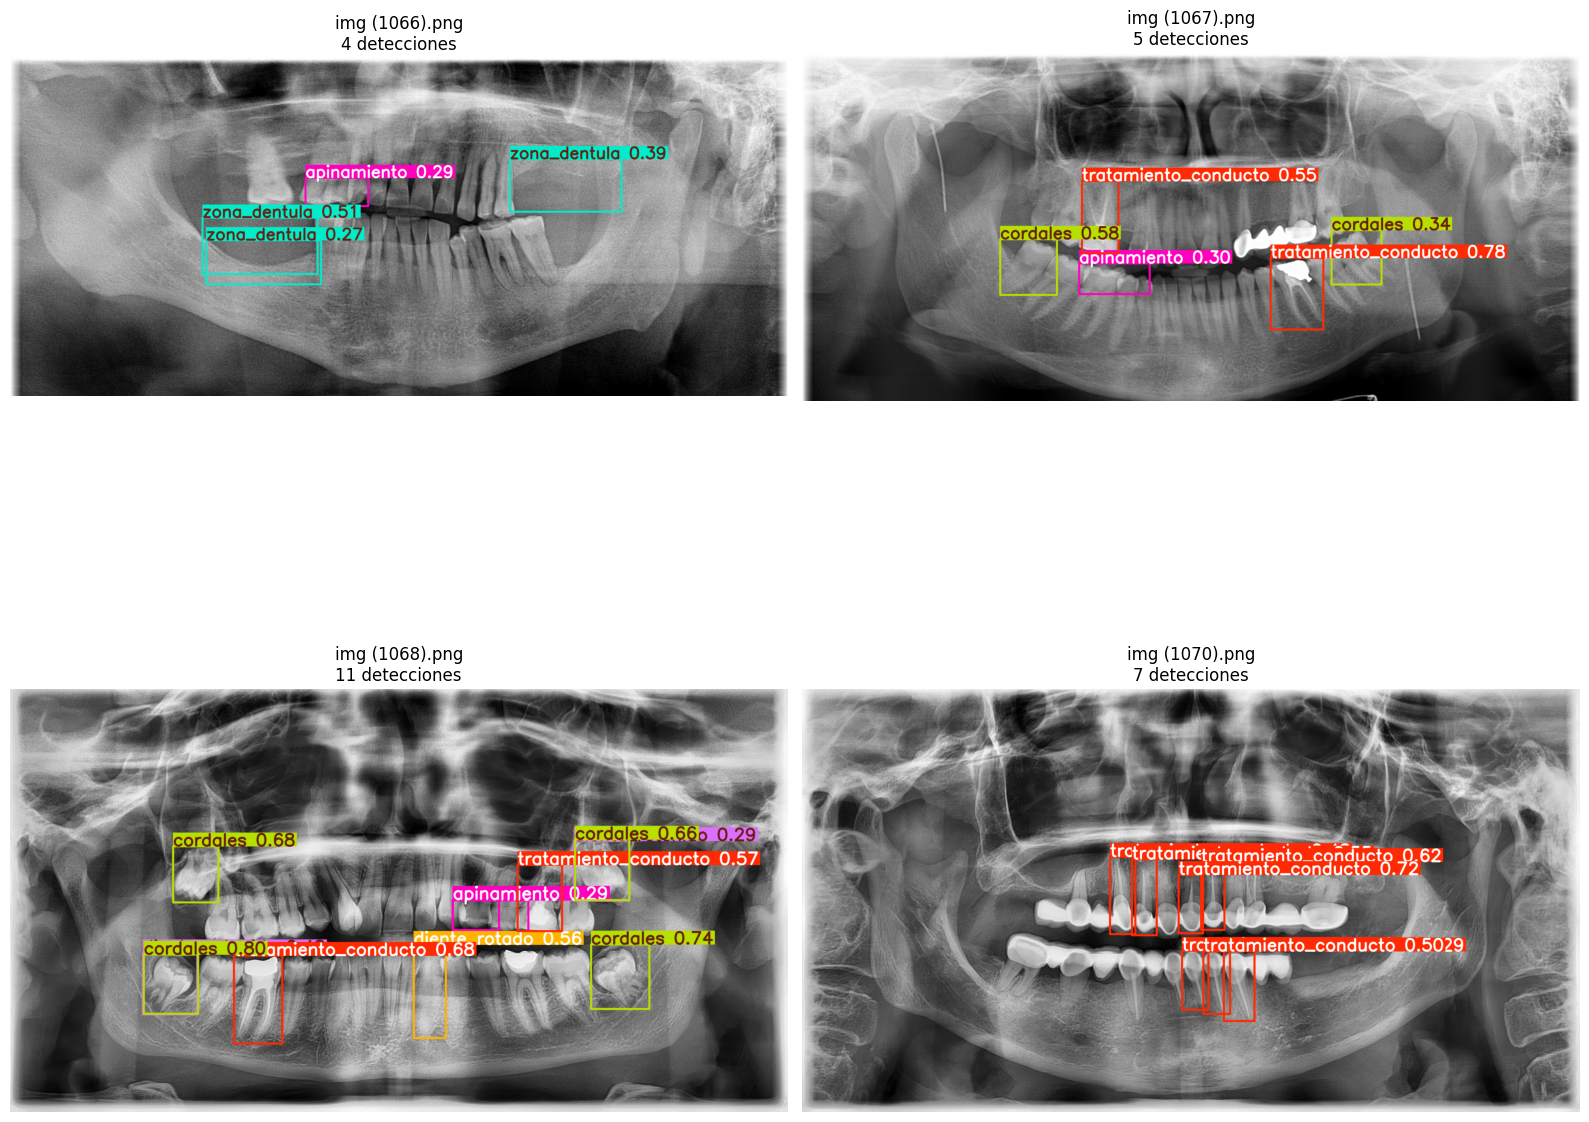


Detecciones en la primera imagen:
  - zona_dentula: 50.8%
  - zona_dentula: 39.4%
  - apinamiento: 29.0%
  - zona_dentula: 26.8%


In [18]:
# Probar con imágenes de validación
if 'best_model' in locals() and 'val_images_dir' in locals() and val_images_dir:
    test_images = list(val_images_dir.glob("*.*"))[:4]
    
    if test_images:
        fig, axes = plt.subplots(2, 2, figsize=(16, 16))
        axes = axes.flatten()
        
        for i, img_path in enumerate(test_images):
            results = best_model.predict(source=str(img_path), verbose=False, conf=0.25)
            result = results[0]
            
            axes[i].imshow(result.plot())
            axes[i].set_title(f"{img_path.name}\n{len(result.boxes)} detecciones")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar detecciones del primer ejemplo
        print("\nDetecciones en la primera imagen:")
        results = best_model.predict(source=str(test_images[0]), verbose=False, conf=0.25)
        for box in results[0].boxes:
            class_id = int(box.cls[0].item())
            conf = box.conf[0].item()
            class_name = CLASSES[class_id] if class_id < len(CLASSES) else f"class_{class_id}"
            print(f"  - {class_name}: {conf*100:.1f}%")
    else:
        print("No se encontraron imágenes de validación")

## 15. Guardar Modelo Final

In [19]:
# Copiar modelo a la raíz del proyecto
if 'best_model_path' in locals() and best_model_path.exists():
    final_model_path = BASE_DIR / "best_dental_kaggle.pt"
    shutil.copy(best_model_path, final_model_path)
    print(f"✅ Modelo final guardado en: {final_model_path}")
    
    # Guardar información del modelo
    info = {
        "dataset": "Kaggle - Radiografías Panorámicas Dentales",
        "model": MODEL_NAME,
        "classes": CLASSES,
        "num_classes": len(CLASSES),
        "epochs": EPOCHS,
        "img_size": IMG_SIZE,
        "batch_size": BATCH_SIZE
    }
    
    info_path = BASE_DIR / "model_info_kaggle.json"
    with open(info_path, 'w', encoding='utf-8') as f:
        json.dump(info, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Información del modelo guardada en: {info_path}")

✅ Modelo final guardado en: C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\best_dental_kaggle.pt
✅ Información del modelo guardada en: C:\Users\memer\OneDrive\Documentos\pathU\proyecto_ia\proyecto_IA\model_info_kaggle.json


## 16. Función de Predicción Reutilizable

In [ ]:
def predict_dental_kaggle(image_path, model_path=None, conf_threshold=0.25):
    """
    Realiza predicción en imagen de rayos X dental (dataset Kaggle).
    
    Args:
        image_path: Ruta a la imagen
        model_path: Ruta al modelo (por defecto usa el mejor modelo)
        conf_threshold: Umbral de confianza
    
    Returns:
        Lista de detecciones
    """
    if model_path is None:
        model_path = BASE_DIR / "best_dental_kaggle.pt"
    
    if not Path(model_path).exists():
        print(f"❌ No se encontró el modelo en: {model_path}")
        return [], None
    
    model = YOLO(str(model_path))
    results = model.predict(source=str(image_path), conf=conf_threshold, verbose=False)
    
    detections = []
    for box in results[0].boxes:
        class_id = int(box.cls[0].item())
        conf = box.conf[0].item()
        bbox = box.xyxy[0].tolist()
        class_name = CLASSES[class_id] if class_id < len(CLASSES) else f"class_{class_id}"
        
        detections.append({
            'class': class_name,
            'class_id': class_id,
            'confidence': conf,
            'bbox': bbox
        })
    
    return detections, results[0]

print("Función predict_dental_kaggle() lista para usar")